In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pythreejs import *
from IPython.display import display
import lorm
from nfft import nfsft
import disc.energy_curveling_s2

In [2]:
s2 = lorm.manif.Sphere2()
mu = lorm.manif.ManifoldPointArrayParameterized(s2)
mu.coords = np.array([[1,1,1],[-1,-1,1],[-1,1,-1],[1,-1,-1]]) + 0.5*np.random.randn(4,3)
mu_m = len(mu.coords)

mu_N = 32
nfsft_plan = nfsft.plan(mu_m,mu_N)
nfsft_plan.set_local_coords(mu.local_coords)
mu_hat = nfsft_plan.compute_Ymatrix_adjoint_multiplication(np.ones(mu_m),mu_N)
mu_hat.array[:] = mu_hat.array[:]/mu_hat[0,0]

In [13]:
# initial curve
s2 = lorm.manif.Sphere2()
points = lorm.manif.ManifoldPointArrayParameterized(s2)
m = 50
local_coords = 2*np.pi*np.random.rand(m,2)
for i in range(m):
    local_coords[i,0] = np.pi/2 + 0.1 * np.random.rand(1)#np.pi/2*(1+0.4*np.sin(10*np.pi*i/m))
    local_coords[i,1] = 2*np.pi*i/m
points.local_coords = local_coords

In [14]:
# setup energy functional
L=7
N=16
energy = disc.energy_curveling_s2.plan(m,N,0.005,L,closed=False)
if N <= mu_hat.N:
    for n in range(N+1):
        energy._mu_hat[n,:] = mu_hat[n,:]
if N > mu_hat.N:
    for n in range(img_hat.N+1):
        energy._mu_hat[n,:] = mu_hat[n,:]

In [15]:
# setup interactive renderview
g1 = BufferGeometry(attributes={'position': BufferAttribute(points.coords, normalized=False) })
m1 = LineBasicMaterial(vertexColors='VertexColors', linewidth=2)
line = Line(g1,m1)

c = PerspectiveCamera(position=[0, 2, 2], up=[0, 2, 0],
                      children=[DirectionalLight(color='white', position=[3, 5, 1], intensity=0.1)])
sphere = Mesh(SphereBufferGeometry(0.99,32,16), MeshStandardMaterial(color='white'))

children = [line, sphere, c,  AmbientLight(color='#FFFFFF')]
for p in mu.coords:
    point = Mesh(SphereBufferGeometry(0.05,1,1), MeshStandardMaterial(color='blue'))
    point.position = (p[0],p[1],p[2])
    children.append( point )

scene = Scene(children=children)

renderer = Renderer(camera=c,
                    scene=scene, 
                    controls=[OrbitControls(controlling=c)])
renderer.width =400
renderer.height =400
display(renderer)

def update_points(p):
    g1.attributes['position'].array = p.coords
    return

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.1, position=(3.0, 5.0,…

In [19]:
# compute local minimizer
method = lorm.optim.ConjugateGradientMethod(max_iter=50)
method.listener = update_points
for i in range(1):
    points = method.run(energy,points)

Initial value: f[0] = 0.01728662247262853
f[1] = 0.01728600761439531
f[2] = 0.01728552593754511
f[3] = 0.017284940903970845
f[4] = 0.017284381923813943
f[5] = 0.01728379432201199
f[6] = 0.017283221802283644
f[7] = 0.017282581885789183
f[8] = 0.017282053638924873
f[9] = 0.01728154628949544
f[10] = 0.017281140026622205
f[11] = 0.01728056571784877
f[12] = 0.017280299535372412
f[13] = 0.017279946794708245
f[14] = 0.017279656825482513
f[15] = 0.017279380945232754
f[16] = 0.017279137199664583
f[17] = 0.017278801101941858
f[18] = 0.01727844659325519
f[19] = 0.01727811886846634
f[20] = 0.0172779462552561
f[21] = 0.017277666424150358
f[22] = 0.0172774569813802
f[23] = 0.017277320017487077
f[24] = 0.017277169501957568
f[25] = 0.017277019801286722
f[26] = 0.017276790886339665
f[27] = 0.01727659709158868
f[28] = 0.017276436049700652
f[29] = 0.017276302051701258
f[30] = 0.01727610430358192
f[31] = 0.01727592172219579
f[32] = 0.01727584916778894
f[33] = 0.017275624473535738
f[34] = 0.017275475694189

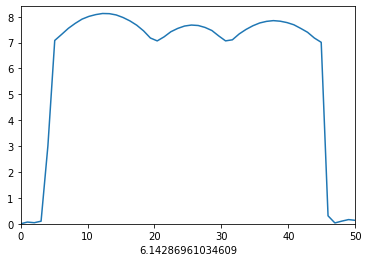

In [20]:
# plot the distance of consecutive points on the curve
fig = plt.figure()
bx = fig.add_subplot(111)
bx.axis(np.array([0,m,0,1.2*energy._L]))
bx.set_xlabel(np.sum(energy._eval_lengths(points.local_coords)))
distance = plt.Line2D(np.linspace(0,m,m),m*energy._eval_lengths(points.local_coords))
bx.add_line(distance)

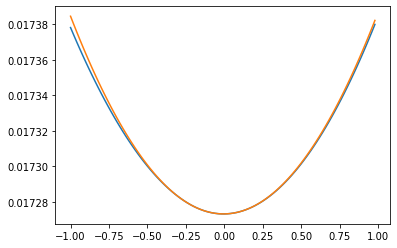

In [21]:
# compute the quadratic approximation to test the gradient and Hessian
%matplotlib inline
v=energy.grad(points)
v.coords = 0.002*np.random.randn(m,3)
f,q, s = lorm.utils.eval_objective_function_with_quadratic_approximation(energy,v)
plt.plot(s,f,s,q)